# Summary
(so far)
- price outliers: simulationPrice 9055.07 and recommendedRetailPrice 6955 
- brand 0 occurs very often  
- customer rating is biased towards 0 and 5  
- There is an unusually large amount of 0 votes -> maybe default value for items that have not been rated yet?
- mostly cheaper items, few very expensive items.  
- also free item  
- Generally brands with a lower number sell more items. maybe because they were introduced earlier in time?  
- one item is sold extremely often, few often and many seldom    
- promotion: hot encode as feature, see difference btw promotion and no promotion and maybe take out as training points  
- day of the week as feature  

# Further Interesting Questions  
- special events in june/july  
-> public holiday or something as additional feature? or do not take into consideration?  
- heuristic analysis of price changes   
-> model for promotion for test data etc?  
- how to orders and prices behave, patterns?  
- price vs (total) quantity sold  
-> does the price change if the product is well sold?  
- does the rating of an item change over time? 
- can the items be clustered?  
- additional feature idea: deviation from recommended retail price  

# Data Exploration: Jana
## Content
### 1. Basic Statistics

### 2. Interesting Questions  
[not done yet]

In [1]:
# change used width of browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# import packages
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE as TSNE
from sklearn.decomposition import PCA
from scipy.interpolate import interpn

In [3]:
plt.rcParams["figure.figsize"] = (17,6)
plt.rcParams.update({'font.size': 10})

In [4]:
# load data
df_train = pd.read_csv('data/orders0206_train.csv', sep='|', parse_dates=['time'])
df_test = pd.read_csv('data/orders0206_train.csv', sep='|', parse_dates=['time'])

df_info = pd.read_csv('data/infos.csv', sep='|', index_col='itemID')
df_items = pd.read_csv('data/items.csv', sep='|', index_col='itemID')
product_prices = df_info['simulationPrice'].to_dict()

df_train_joined = df_train.join(df_info, on='itemID').join(df_items, on='itemID')

In [5]:
df_train_joined.columns

Index(['time', 'transactID', 'itemID', 'order', 'salesPrice',
       'simulationPrice', 'promotion', 'brand', 'manufacturer',
       'customerRating', 'category1', 'category2', 'category3',
       'recommendedRetailPrice'],
      dtype='object')

## 1. Basic Statistics

### 1.1 Value Ranges 

In [6]:
df_train_joined.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,transactID,itemID,order,salesPrice,simulationPrice,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
count,1.72736e+06,1.72736e+06,1.72736e+06,1.72736e+06,1.72736e+06,1.72736e+06,1.72736e+06,1.72736e+06,1.72736e+06,1.72736e+06,1.72736e+06,1.72736e+06
mean,871311,5178.75,1.23986,37.924,34.5326,43.6206,111.535,2.41217,4.16412,23.1868,4.15936,32.6092
std,544901,2444.32,0.658818,132.353,131,56.723,64.4136,2.26837,1.93347,12.6831,2.12434,99.7535
min,3,1,1,0,0.38,0,1,0,1,1,1,2.46
25%,422208,3502,1,7.43,6.1,0,66,0,2,10,2,10.83
50%,845864,5139,1,17.45,14.81,0,100,3,4,23,4,16.29
75%,1.26853e+06,7150,1,34.99,30.96,92,164,5,5,32,6,26.26
max,2.29404e+06,10463,100,9387.02,9055.07,265,253,5,8,51,8,6955


#### Observations:
- simulationPrice 9055.07 and recommendedRetailPrice 6955 look like outliers
- brand 0 occurs very often  
- customer rating is biased towards 0 and 5

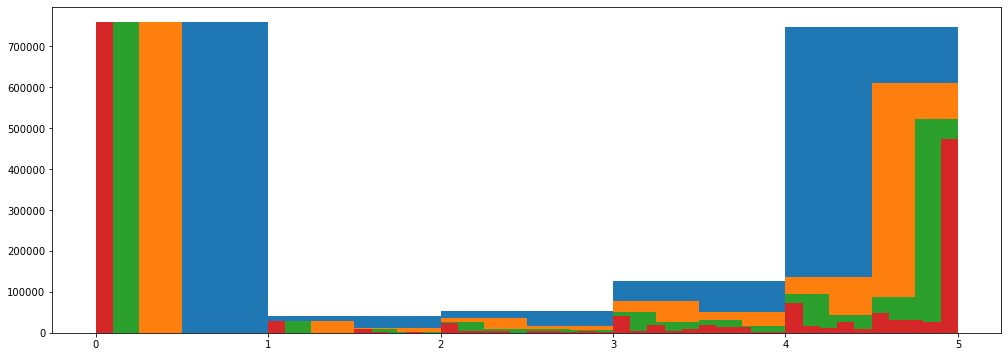

In [7]:
# plot a histogram with 5 bins
plt.hist(df_train_joined['customerRating'], bins=5)

# plot a histogram with 10 bins
plt.hist(df_train_joined['customerRating'], bins=10)

# plot a histogram with 20 bins
plt.hist(df_train_joined['customerRating'], bins=20)

# plot a histogram with 50 bins
plt.hist(df_train_joined['customerRating'], bins=50)

# show the figure
plt.show()

## >>insight
There is an unusually large amount of 0 votes -> maybe default value for items that have not been rated yet?

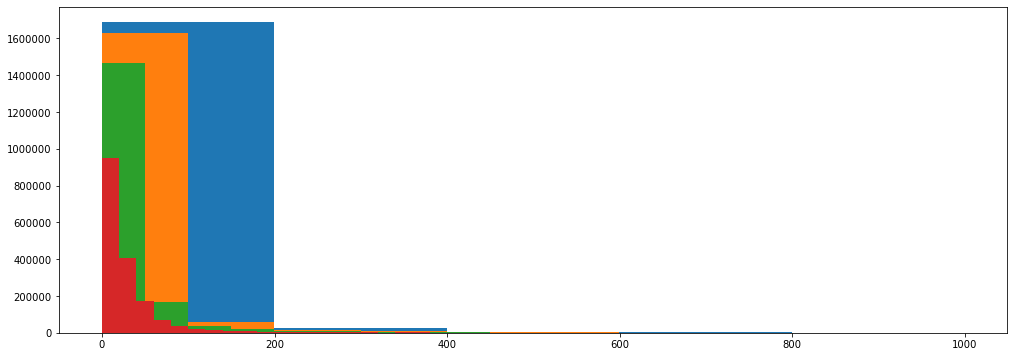

In [8]:
# plot a histogram with 5 bins
plt.hist(df_train_joined[df_train_joined['salesPrice'] < 1000]['salesPrice'], bins=5)

# plot a histogram with 10 bins
plt.hist(df_train_joined[df_train_joined['salesPrice'] < 1000]['salesPrice'], bins=10)

# plot a histogram with 20 bins
plt.hist(df_train_joined[df_train_joined['salesPrice'] < 1000]['salesPrice'], bins=20)

# plot a histogram with 50 bins
plt.hist(df_train_joined[df_train_joined['salesPrice'] < 1000]['salesPrice'], bins=50)

# show the figure
plt.show()

In [9]:
df_train_joined.groupby('salesPrice').count()

,time,transactID,itemID,order,simulationPrice,promotion,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
salesPrice,,,,,,,,,,,,,
0.00,209,209,209,209,209,199,209,209,209,209,209,209,209
0.33,67,67,67,67,67,67,67,67,67,67,67,67,67
0.38,44,44,44,44,44,0,44,44,44,44,44,44,44
0.42,3,3,3,3,3,0,3,3,3,3,3,3,3
0.43,2,2,2,2,2,0,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8529.41,2,2,2,2,2,0,2,2,2,2,2,2,2
8813.07,2,2,2,2,2,0,2,2,2,2,2,2,2
9053.08,12,12,12,12,12,0,12,12,12,12,12,12,12


## >> insight
- mostly cheaper items, few very expensive items.  
- also free item

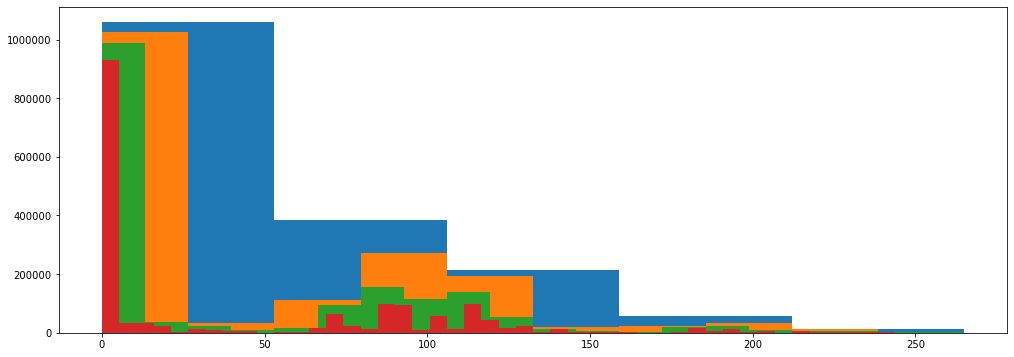

In [10]:
# plot a histogram with 5 bins
plt.hist(df_train_joined['brand'], bins=5)

# plot a histogram with 10 bins
plt.hist(df_train_joined['brand'], bins=10)

# plot a histogram with 20 bins
plt.hist(df_train_joined['brand'], bins=20)

# plot a histogram with 50 bins
plt.hist(df_train_joined['brand'], bins=50)

# show the figure
plt.show()

## >> insight
Generally brands with a lower number sell more items.  
-> What about the average sales price per brand?

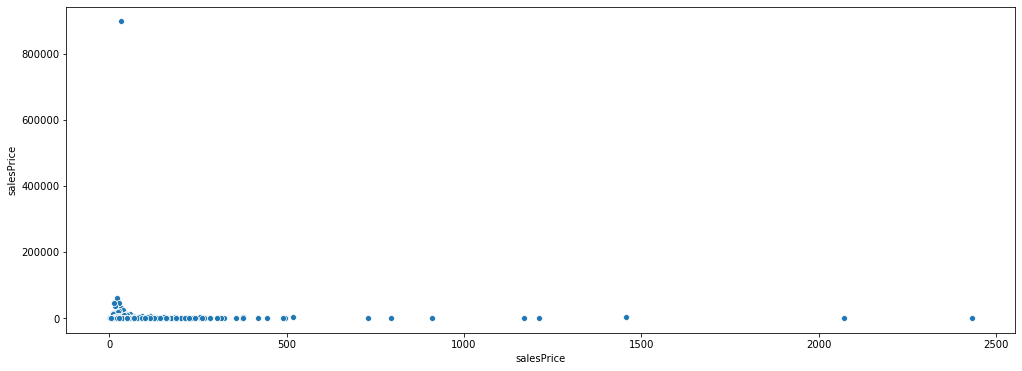

In [11]:
sb.scatterplot(x=df_train_joined.groupby('brand').mean()['salesPrice'], y=df_train_joined.groupby('brand').count()['salesPrice'])
#df_train_joined.groupby('brand').mean()[['salesPrice', 'simulationPrice', 'customerRating', 'recommendedRetailPrice']]

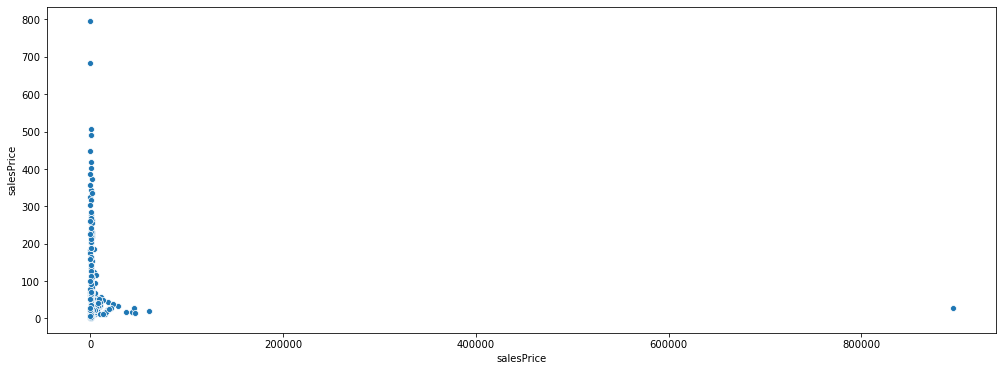

In [12]:
sb.scatterplot(x=df_train_joined[df_train_joined['salesPrice'] < 1000].groupby('brand').count()['salesPrice'], 
               y=df_train_joined[df_train_joined['salesPrice'] < 1000].groupby('brand').mean()['salesPrice'])
#df_train_joined.groupby('brand').mean()[['salesPrice', 'simulationPrice', 'customerRating', 'recommendedRetailPrice']]

## >> insight
one item is sold extremely often, few often and many seldom

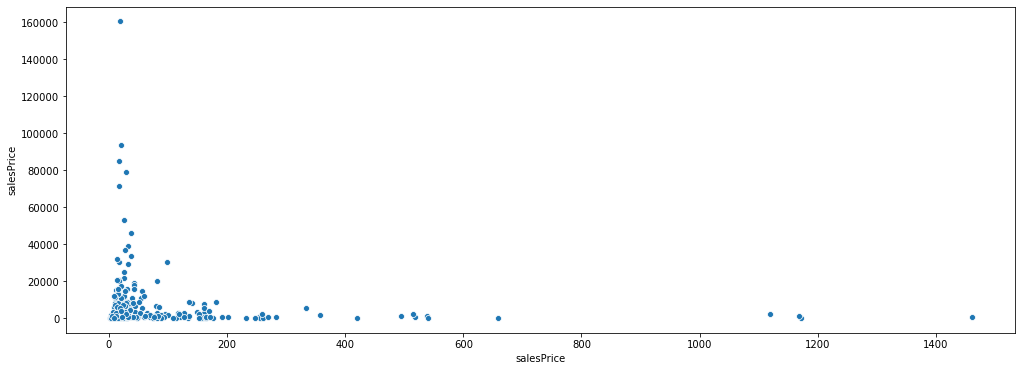

In [13]:
sb.scatterplot(x=df_train_joined.groupby('manufacturer').mean()['salesPrice'], y=df_train_joined.groupby('manufacturer').count()['salesPrice'])
#df_train_joined.groupby('brand').mean()[['salesPrice', 'simulationPrice', 'customerRating', 'recommendedRetailPrice']]

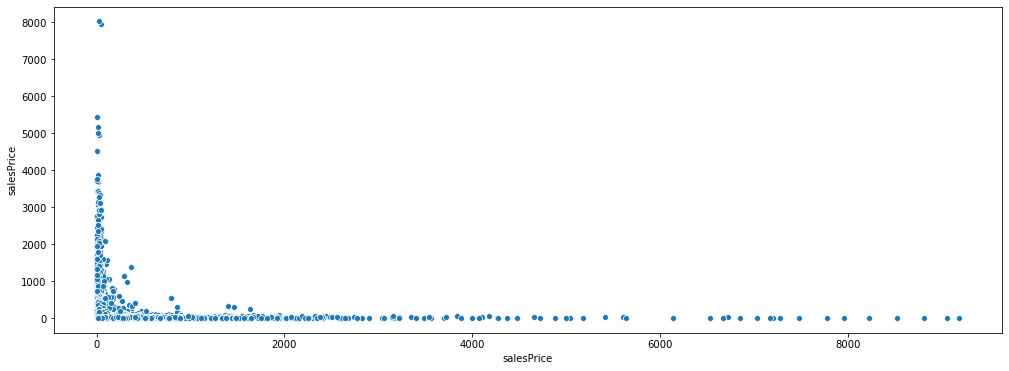

In [14]:
# how often where the items sold?
sb.scatterplot(x=df_train_joined.groupby('itemID').mean()['salesPrice'], y=df_train_joined.groupby('itemID').count()['salesPrice'])

In [15]:
# # data points over time
# sb.countplot(data=df_train_joined, x="time")
# plt.plot()

### 1.2 Clustering
Visual outlier detection

In [16]:
df_train_joined.promotion = df_train_joined.promotion.fillna(0)

In [17]:
# pca: principal component analysis
a_pca = PCA(n_components=2).fit_transform(df_train_joined[[ 'salesPrice',
        'brand', 'manufacturer',
       'customerRating', 'category1', 'category2', 'category3',
       'recommendedRetailPrice']])

# # export transformed data as csv file
np.savetxt("pca_orders0206_train.csv", a_pca, delimiter=",")

In [18]:
# tsne: t-distributed stochastic neighbor embedding
a_tsne = TSNE(n_components=2).fit_transform(df_train_joined[['salesPrice',
        'brand', 'manufacturer',
       'customerRating', 'category1', 'category2', 'category3',
       'recommendedRetailPrice']])
# export transformed data as csv file
np.savetxt("tsne_orders0206_train.csv", a_tsne, delimiter=",")

In [19]:
df_tsne = pd.read_csv("tsne_orders0206_train.csv", header=None)
df_pca = pd.read_csv("pca_orders0206_train.csv", header=None)

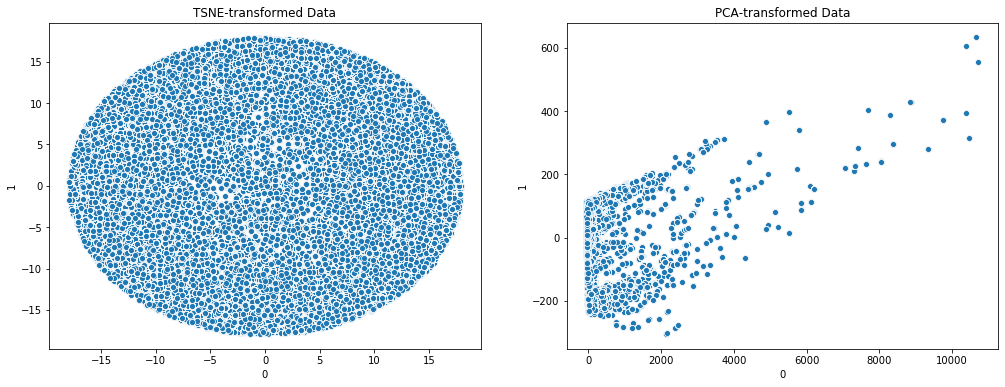

In [20]:
# create t-sne and pca scatter plot
f, axes = plt.subplots(1, 2)
plot1 = sb.scatterplot( x=df_tsne[0], y=df_tsne[1],  ax=axes[0])
plot1.set(title="TSNE-transformed Data")
plot2 = sb.scatterplot( x=df_pca[0], y=df_pca[1],  ax=axes[1])
plot2.set(title="PCA-transformed Data")
plt.show()

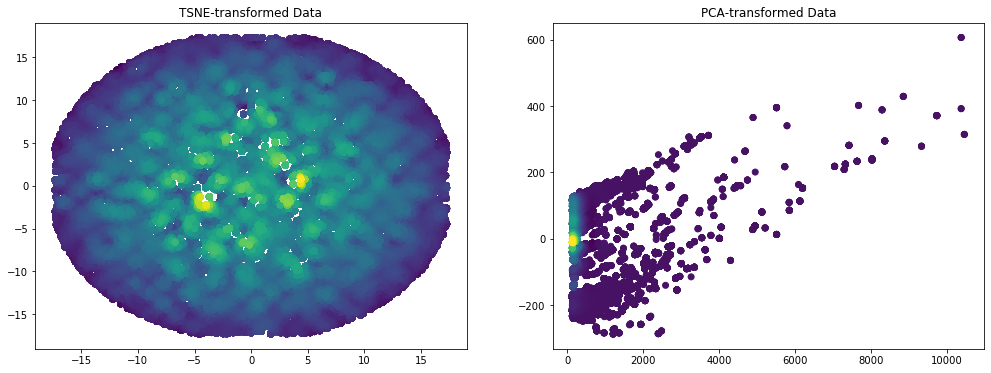

In [21]:
# plot with density
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    return ax

f, axes = plt.subplots(1, 2)
plot1 = density_scatter( df_tsne[0], df_tsne[1], bins = [30,30], ax=axes[0])
plot1.set(title="TSNE-transformed Data")
plot2 = density_scatter( df_pca[0], df_pca[1], bins = [30,30], ax=axes[1])
plot2.set(title="PCA-transformed Data")
plt.show()

In [24]:
# pca: principal component analysis
a_pca = PCA(n_components=2).fit_transform(df_items)

# # export transformed data as csv file
np.savetxt("pca_items.csv", a_pca, delimiter=",")

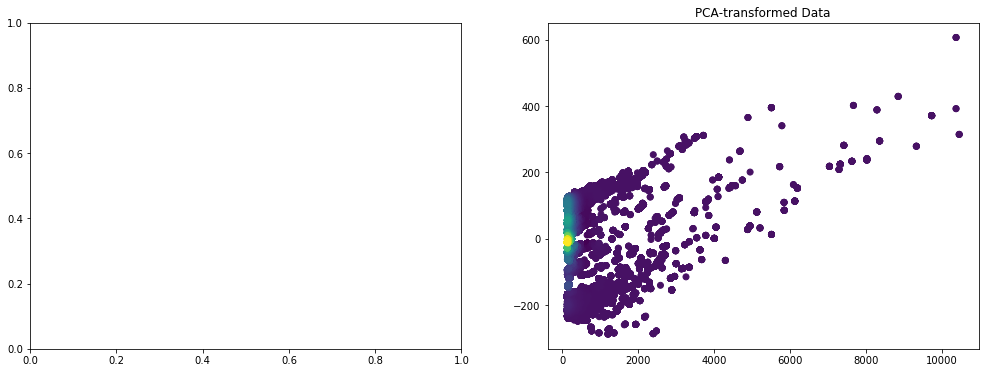

In [25]:
# plot with density
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    return ax

f, axes = plt.subplots(1, 2)
# plot1 = density_scatter( df_tsne[0], df_tsne[1], bins = [30,30], ax=axes[0])
# plot1.set(title="TSNE-transformed Data")
plot2 = density_scatter( df_pca[0], df_pca[1], bins = [30,30], ax=axes[1])
plot2.set(title="PCA-transformed Data")
plt.show()

## 2. Interesting Questions